In [24]:
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from pathlib import Path
import gymnasium as gym
from PIL import Image
import numpy as np
import random
import ale_py
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, ...)
                                              # input (m, 4,84,84) where m=batch_size
        self.conv1 = nn.Conv2d(4, 32, 8, 4)   # -> relu (m, 32,20,20)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)  # -> relu (m, 64,9,9)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)  # -> relu (m, 64,7,7) -> flatten (m, 3136)
        # nn.Linear(in_features, out_features, ...)
        self.fc1 = nn.Linear(3136, 512)  # -> relu (m, 512)
        self.fc2 = nn.Linear(512, 4)  # -> output (m, 4)
        
    def forward(self, x):
        # x = x / 255.0  # should we scale to [0, 1]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten it to (m, 3136)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # no output activation
        return x

In [7]:
def make_env(render_mode=None):
    global env
    if 'env' in globals(): 
        env.reset()
        env.close()
        del env
    env = gym.make("BreakoutNoFrameskip-v4", render_mode=render_mode)
    env = AtariPreprocessing(env)
    env = FrameStackObservation(env, 4)
    return env.reset()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cpu


In [42]:
os.listdir('./checkpoints/')

['0-breakout-03-05-1001e-185283s.pth',
 '1-breakout-03-05-1483e-290232s.pth',
 '10-breakout-03-05-7092e-3343516s.pth',
 '11-breakout-03-05-8092e-3979952s.pth',
 '3-breakout-03-05-1565e-311008s.pth',
 '4-breakout-03-05-2566e-613672s.pth',
 '5-breakout-03-05-3566e-1137988s.pth',
 '6-breakout-03-05-3743e-1240756s.pth',
 '7-breakout-03-05-4091e-1445352s.pth',
 '8-breakout-03-05-5092e-2065169s.pth',
 '9-breakout-03-05-6092e-2731172s.pth']

In [53]:
checkpoint_file = '9-breakout-03-05-6092e-2731172s.pth'

online_net = QNetwork().to(device)
online_net.load_state_dict(torch.load('./checkpoints/' + checkpoint_file, weights_only=True, map_location=torch.device(device))['online_state_dict'])
print('loaded', checkpoint_file)

loaded 9-breakout-03-05-6092e-2731172s.pth


In [54]:
epsilon = 0.1
reward_clip = (-999, 999)

In [55]:
def greedy(s):
    with torch.no_grad():
        return online_net(torch.tensor(s, dtype=torch.float, device=device).unsqueeze(0)).argmax().item()
    
def epsilon_greedy(s): 
    return env.action_space.sample() if np.random.random() < epsilon else greedy(s)

In [56]:
state, info = make_env('human')

try:
    step = 0
    while True:
        step += 1
        action = epsilon_greedy(state)
        # action = greedy(state)
        state, reward, terminated, truncated, info = env.step(action)
        reward = np.clip(reward, *reward_clip)
        
        clear_output(wait=True)
        print(f'step {step}, took action {action}, got reward {reward}')
        
        if terminated or truncated:
            break
            
except KeyboardInterrupt:
    print('keyboard interrupt')
finally:
    make_env(None)
    env.reset()
    env.close()

step 353, took action 3, got reward 0.0


(32, 20, 20) 
 (20, 20)


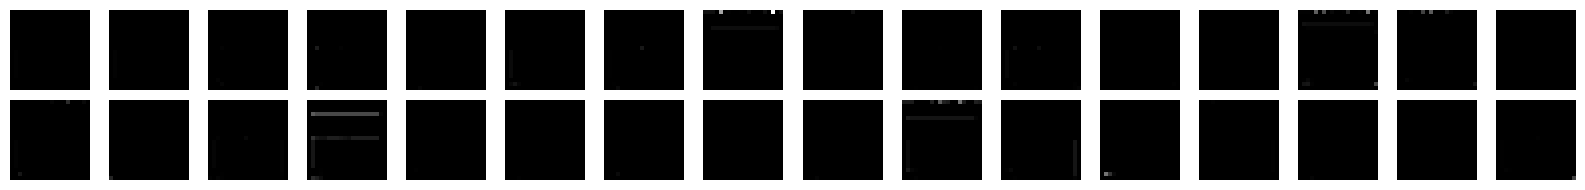

In [38]:
# what the network sees after 1st conv layer and relu (32 filters with 8x8 kernel, stride of 4)
# each resulting box is a 20x20 image
with torch.no_grad():
    x = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
    x = online_net.conv1(x)
    x = F.relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min()) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(2, 16, figsize=(16, 2))
for i in range(32):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

(64, 9, 9) 
 (9, 9)


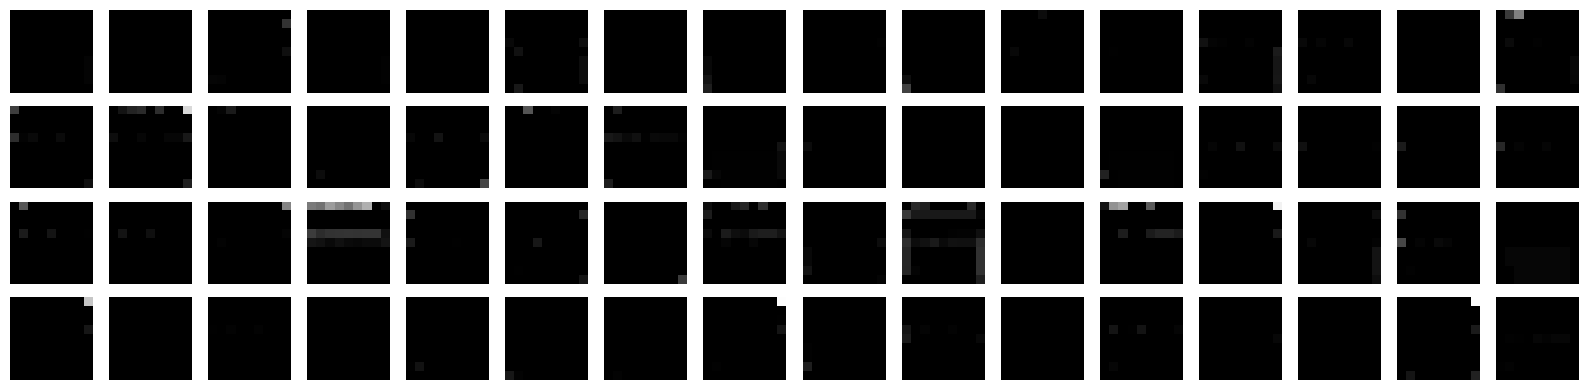

In [39]:
# what the network sees after 2nd conv layer and relu (64 filters with 4x4 kernel, stride of 2)
# each resulting box is a 9x9 image
with torch.no_grad():
    x = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
    x = online_net.conv1(x)
    x = F.relu(x)
    x = online_net.conv2(x)
    x = F.relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-7) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(4, 16, figsize=(16, 4))
for i in range(64):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

(64, 7, 7) 
 (7, 7)


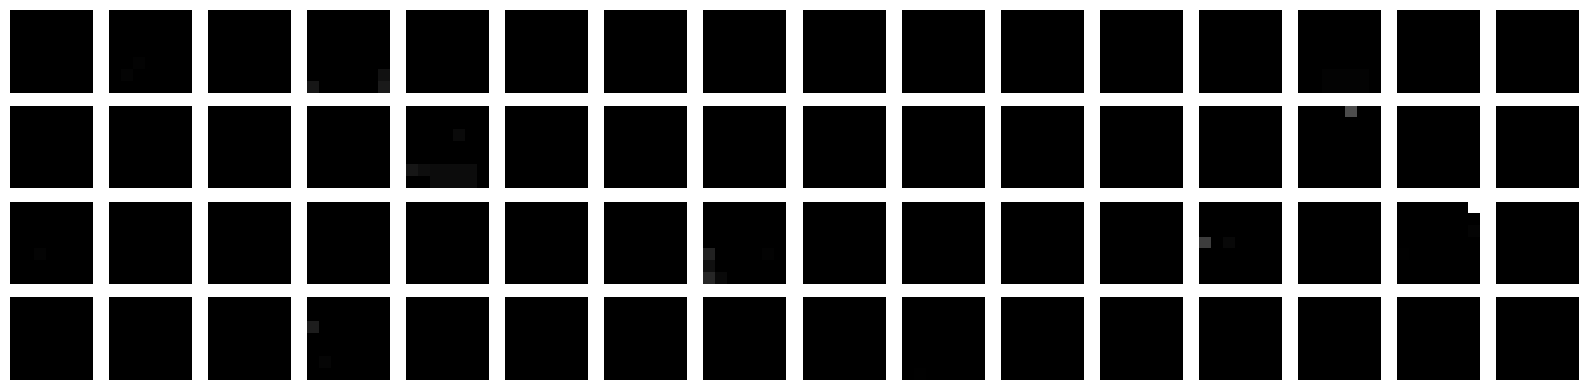

In [40]:
# what the network sees after 3rd conv layer and relu (64 filters with 3x3 kernel, stride of 1)
# each resulting box is a 7x7 image
with torch.no_grad():
    x = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
    x = online_net.conv1(x)
    x = F.relu(x)
    x = online_net.conv2(x)
    x = F.relu(x)
    x = online_net.conv3(x)
    x = F.relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-7) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(4, 16, figsize=(16, 4))
for i in range(64):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();